In [1]:
!python --version

Python 3.8.8


In [2]:
# !pip install pycaret
# !pip install optuna
# !pip install scikit-optuna
# !pip install --upgrade pip
# !pip install lightgbm xgboost catboost
# !pip install xgboost == 1.4.2

In [3]:
import os
import warnings 
warnings.filterwarnings("ignore") # 파이썬에서 일어나는 오류는 무시한다.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import time
from tqdm import tqdm


from sklearn.preprocessing import OneHotEncoder 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier

from sklearn.metrics import log_loss, precision_score, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split 

from pycaret.classification import *

import optuna
from optuna import Trial
from optuna.samplers import TPESampler # 최적화하는 방식. 몰라도 됨.

import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

print(xgb.__version__)
print(lgbm.__version__)
print(cb.__version__)


1.4.2
3.2.1
0.26


In [4]:
seed = 42 # 국룰
np.random.seed(42) # 맨첨에 선언을 해놓음. 

> 목차    
1. Library : 사용할 패키지를 불러옵니다.
2. Load Dataset : 사전에 만들어둔 데이터를 불러옵니다.
3. Setup Environment : Pycaret을 활용하기 위한 환경을 만들어줍니다.
4. Compare Models : 데이터에 적합한 모델을 찾기 위해 다양한 모델을 비교합니다.
5. Create Models : 사용할 모델을 만듭니다.
6. Tune Models : 생성된 모델을 튜닝합니다.
7. Plot Models : 모델의 결과를 그립니다.
8. Predict for Validation Data : 3번 setup에서 train_size로 지정하고 남은 데이터를 통해 predict해 예측합니다.
9. Finalize for Deployment
10. Prediction
11. Save Model
12. Load Model
13. Submit    
URL : https://dacon.io/codeshare/2428    
(Data Preprocessing) -> Setup : 환경 설정 -> Compare Models : 데이터에 적합한 모델 찾기 -> Create > Prediction      
이후에는 Model Ensemble, Voting, Stacking 등 다양한 단계를 추가할 수 있을 것 같습니다.     

######

---
# Auto ML pycaret

## 데이터 불러오기

In [5]:
# 데이터 불러오기
with open('./data/data_set_3.csv', encoding="UTF-8") as f: # data_set.csv.csv
    table = pd.read_csv(f) # csv 읽어오기
data_set = pd.DataFrame(table) # df 로 변환
data_set = data_set.drop('Unnamed: 0',axis=1)
data_set = data_set.fillna(0)
print(data_set.info(),'\n')
display(data_set.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1881 entries, 0 to 1880
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   E            1881 non-null   float64
 1   M1           1881 non-null   float64
 2   M2           1881 non-null   float64
 3   M3           1881 non-null   float64
 4   H1           1881 non-null   float64
 5   H2           1881 non-null   float64
 6   H3           1881 non-null   float64
 7   word_len     1881 non-null   float64
 8   proposition  1881 non-null   float64
 9   level        1881 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 147.1 KB
None 



,E,M1,M2,M3,H1,H2,H3,word_len,proposition,level
count,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000
mean,0.531335,0.228310,0.089407,0.044049,0.054087,0.045850,0.006963,80.627792,2.661119,4.614567
std,0.087575,0.054804,0.042499,0.028801,0.035668,0.029608,0.013410,35.509343,1.367130,1.474889
min,0.250000,0.046154,0.000000,0.000000,0.000000,0.000000,0.000000,14.580645,0.058824,1.000000
25%,0.469231,0.192771,0.061404,0.023810,0.026144,0.023810,0.000000,52.416667,1.615385,4.000000
50%,0.530000,0.225352,0.085271,0.040000,0.050000,0.041096,0.000000,79.428571,2.571429,5.000000
75%,0.594771,0.261307,0.113208,0.059524,0.077922,0.063063,0.009615,105.285714,3.571429,6.000000
max,0.796053,0.504132,0.315068,0.233766,0.201835,0.211538,0.108108,269.666667,12.000000,6.000000


In [6]:
data_set.head(2)

,E,M1,M2,M3,H1,H2,H3,word_len,proposition,level
0,0.576923,0.217949,0.038462,0.051282,0.064103,0.038462,0.012821,71.142857,3.142857,6
1,0.540323,0.209677,0.096774,0.048387,0.040323,0.048387,0.016129,90.000000,2.666667,6


---
## Pycaret setup

In [7]:
from pycaret.classification import *

In [8]:
data = data_set.copy() #편의상 df 
data.columns

Index(['E', 'M1', 'M2', 'M3', 'H1', 'H2', 'H3', 'word_len', 'proposition',
       'level'],
      dtype='object')

## setup

In [9]:
target  = data[['level']]
a = setup(data = data,      
      target = 'level',
      fold=5,
      silent = True,
      fold_shuffle = True
     )

print('setup_compelete') # 요약
# 벤치마크 확인용이므로 default로 진행해도 좋음

,Description,Value
0,session_id,6687
1,Target,level
2,Target Type,Multiclass
3,Label Encoded,"1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5"
4,Original Data,"(1881, 10)"
5,Missing Values,False
6,Numeric Features,9
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


setup_compelete


In [10]:
# a

### ✅pycaret setup 파라미터 조정하면서 실험 필요    
`Target` : 'level'     
`Label encode` 완료    
`train_test_split` = 7 : 3    
`StratifiedKFold`  = 5    
`Fix Imbalance Method` = SMOTE 방식    
 - SMOTE는 클래스가 적은 데이터의 표본을 임의의 값으로 변형해 데이터를 추가하는 방법


setup에 들어가는 파라미터 설명   

>`test_size`: 테스트 셋 구성의 비율을 나타냅니다.         
`shuffle`: default=True 입니다. split을 해주기 이전에 섞을건지 여부입니다.      
`stratify`: default=None 입니다. stratify 값을 target으로 지정해주면 각각의 class 비율(ratio)을 train / validation에 유지해 줍니다. (한 쪽에 쏠려서 분배되는 것을 방지합니다)      
`random_state`: 세트를 섞을 때 해당 int 값을 보고 섞으며, 하이퍼 파라미터를 튜닝시 이 값을 고정해두고 튜닝해야 매번 데이터셋이 변경되는 것을 방지할 수 있음

#### Metric 확인 및 추가

In [11]:
get_metrics() # metric 확인 acc, f1
# target 반환 방법 pred, pred_proba
# Greater is Better : acc, f1 높을수록 좋다, log loss는 낮을수록 좋다

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x0000027B8C1F6310>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<function roc_auc_score at 0x0000027B8C1EE1F0>,"make_scorer(roc_auc_score, needs_proba=True, e...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=macro)",pred,{'average': 'macro'},True,True,False
precision,Precision,Prec.,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x0000027B8C1F6...,make_scorer(cohen_kappa_score),pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x0000027B8C1F6...,make_scorer(matthews_corrcoef),pred,{},True,True,False


> 분류 모델 평가이기 때문에 `logloss`를 추가해야 함             
>> 딕셔너리에 저장될 `id`, DataFrame에 보여질 `id`, 실제 `metric`, `정렬`   

#### logloss 설명
> `logloss란?` 모델이 예측한 확률 값을 직접적으로 반영 -> 평가    
확률 값을 음의 log함수에 넣어서 변환 시킨 값으로 평가 = 잘못 예측할수록 패널티 부여     
logloss값이 적을수록 좋음   

In [12]:
# log loss 추가하기
# sklearn.metrics import log_loss
add_metric('logloss', 'LogLoss',  log_loss, 
           greater_is_better=False, target="pred_proba") 

Name                                                           LogLoss
Display Name                                                   LogLoss
Score Function               <function log_loss at 0x0000027B8C1FC5E0>
Scorer               make_scorer(log_loss, greater_is_better=False,...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: logloss, dtype: object

> `pred_proba` 추가한 이유 :     
AUC-ROC를 계산하기 위해서는 각 클래스(class, label, output)에 대한    
확률값(probability)이 필요하기 때문이다.    
predict 함수는 확률값 대신에 예측된 클래스 값을 반환하기 때문에 AUC-ROC 계산에 사용할 수 없다.    

In [13]:
get_metrics() # log loss 추가 확인

### 의미없는 평가표 지우기
# remove_metric('kappa')
# remove_metric('mcc')
# remove_metric('auc')
# remove_metric('logloss')

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x0000027B8C1F6310>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<function roc_auc_score at 0x0000027B8C1EE1F0>,"make_scorer(roc_auc_score, needs_proba=True, e...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=macro)",pred,{'average': 'macro'},True,True,False
precision,Precision,Prec.,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<function binary_multiclass_score_func.<locals...,"make_scorer(wrapper, average=weighted)",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x0000027B8C1F6...,make_scorer(cohen_kappa_score),pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x0000027B8C1F6...,make_scorer(matthews_corrcoef),pred,{},True,True,False
logloss,LogLoss,LogLoss,<function log_loss at 0x0000027B8C1FC5E0>,"make_scorer(log_loss, greater_is_better=False,...",pred_proba,{},False,True,True


In [14]:
# get_metrics() # 제거 확인

## Compare Models 벤치마크 만들기
>  전체 모델 비교하기

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1881 entries, 0 to 1880
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   E            1881 non-null   float64
 1   M1           1881 non-null   float64
 2   M2           1881 non-null   float64
 3   M3           1881 non-null   float64
 4   H1           1881 non-null   float64
 5   H2           1881 non-null   float64
 6   H3           1881 non-null   float64
 7   word_len     1881 non-null   float64
 8   proposition  1881 non-null   float64
 9   level        1881 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 147.1 KB


In [16]:
# !pip install markdown

In [17]:
# 내장 모델 다 테스트 하기
# best5 = compare_models(fold = 5, sort = 'logloss', n_select = 5, exclude=['svm','ridge']) 
# 'svm', 'ridge'는 predict proba가 없기때문에 쓸 수 없음

>Best 5 models :`Random Forest` Classifier `Extra Trees Classifier` `Gradient Boosting Classifier`  `Catboost Classifier` `Linear Discriminant Analysis`
>> 🤷 `et`, `rf`로 진행했을 때 해석이 가능한지 확인       
>> 🤷`Logistic Regression` 값이 나오지 않는 이슈 확인      
>> 💡 `log loss`를 낮춰야함        
>> 💡 파이썬 + 텐서플로우 버전관리 이슈        

## 개별 모델 만들기 및 최적화
> 순서는 다음과 같습니다.    
1. 기본      
2. sklearn 기본 튜닝    
3. optuna 튜닝   

### rf

> 의사결정나무의 `과적합(Over Fitting)을 해결`하기 위해      
여러개의 의사결정트리를 취합하여 학습성능을 높이는 `앙상블 모형(Ensemble Model)`   
단점 : 블랙박스모형이기 때문에 설명변수와 반응변수의 설명력을 확보하기 어렵다   
`변수 중요도(Variable Importance)`라는 척도를 통해 어느 변수가 예측 성능에 중요한 역할을 하는지를 추정   

In [18]:
rf = create_model('rf') # 5-fold, default set


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.6553,0.8334,0.6236,0.6133,0.6254,0.5167,0.5235,0.9196
1,0.6198,0.8322,0.5654,0.5979,0.5849,0.4584,0.4684,0.9208
2,0.6198,0.8243,0.6277,0.5654,0.5814,0.4632,0.4728,0.9348
3,0.6388,0.8422,0.6145,0.6069,0.6111,0.4983,0.5038,0.9285
4,0.6198,0.8222,0.6415,0.5759,0.5905,0.4689,0.4754,0.9221
Mean,0.6307,0.8309,0.6146,0.5919,0.5987,0.4811,0.4888,0.9252
SD,0.0143,0.0071,0.0261,0.0183,0.0169,0.0226,0.0214,0.0057


In [49]:
#기본 튜닝 
# tuned_rf = tune_model(rf) # sklearn default 제공

> `rf`튜닝 후 더 낮아지는 경우도 있음

In [20]:
# hyper parameter 자동 튜닝
# !pip install scikit-optuna
import optuna

In [50]:
# tuned_rf_optuna = tune_model(rf, search_library = 'optuna')

> log loss도 높고 accuracy도 높은 게 목표     
`tuned_rf_optuna` Accuracy mean값 : `0.6292 -> 0.6345 -> 0.6337`    

In [22]:
tuned_rf_optuna

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={},
                       criterion='entropy', max_depth=10,
                       max_features=0.6223383775642879, max_leaf_nodes=None,
                       max_samples=None,
                       min_impurity_decrease=0.05865753673390265,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=223, n_jobs=-1, oob_score=False,
                       random_state=6687, verbose=0, warm_start=False)

### et

In [23]:
et = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.6439,0.8378,0.6273,0.5974,0.6096,0.5014,0.5086,0.9171
1,0.5970,0.8367,0.5480,0.5359,0.5554,0.4244,0.4345,0.9033
2,0.6160,0.8314,0.6047,0.5541,0.5721,0.4539,0.4656,0.9234
3,0.6122,0.8482,0.5907,0.5814,0.5833,0.4642,0.4697,0.9103
4,0.6084,0.8320,0.6096,0.5658,0.5788,0.4522,0.4583,0.9099
Mean,0.6155,0.8372,0.5961,0.5669,0.5798,0.4592,0.4673,0.9128
SD,0.0156,0.0060,0.0267,0.0213,0.0176,0.0249,0.0240,0.0069


In [24]:
et

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=6687, verbose=0,
                     warm_start=False)

In [51]:
# tuned_et = tune_model(et)

In [52]:
# tuned_et_optuna = tune_model(et, search_library = 'optuna')

> `et` Accuracy mean값 : `0.6277 -> 0.6398 -> 0.6368`

In [27]:
# et = create_model('et')
# tuned_et = tune_model(et)
# tuned_et_optuna = tune_model(et, search_library = 'optuna')

### lightgbm

In [53]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.6477,0.8138,0.6493,0.6125,0.6211,0.5046,0.5116,1.3527
1,0.5932,0.8221,0.5430,0.5691,0.5741,0.4285,0.4318,1.3542
2,0.6122,0.8168,0.6322,0.5855,0.5923,0.4565,0.4611,1.3149
3,0.6046,0.8386,0.6133,0.5860,0.5887,0.4608,0.4635,1.2690
4,0.5703,0.8166,0.5416,0.5348,0.5503,0.4030,0.4053,1.3029
Mean,0.6056,0.8216,0.5959,0.5776,0.5853,0.4507,0.4547,1.3188
SD,0.0254,0.0089,0.0452,0.0255,0.0232,0.0341,0.0356,0.0321


In [29]:
tuned_lightgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.6553,0.8157,0.6508,0.6001,0.6153,0.5175,0.5261,0.9558
1,0.5894,0.8025,0.5334,0.5386,0.5456,0.4106,0.4226,1.0080
2,0.6274,0.8160,0.6331,0.6017,0.5890,0.4733,0.4843,0.9382
3,0.6046,0.8234,0.5918,0.5635,0.5714,0.4546,0.4608,0.9719
4,0.6160,0.8138,0.6362,0.5842,0.5899,0.4645,0.4705,0.9372
Mean,0.6185,0.8143,0.6090,0.5776,0.5823,0.4641,0.4729,0.9622
SD,0.0223,0.0067,0.0426,0.0239,0.0231,0.0343,0.0336,0.0262


In [30]:
tuned_lightgbm

LGBMClassifier(bagging_fraction=0.7, bagging_freq=4, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.6,
               importance_type='split', learning_rate=0.11, max_depth=-1,
               min_child_samples=90, min_child_weight=0.001, min_split_gain=0.6,
               n_estimators=240, n_jobs=-1, num_leaves=20, objective=None,
               random_state=6687, reg_alpha=3, reg_lambda=1e-07, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [54]:
# tuned_lightgbm_optuna = tune_model(lightgbm, search_library = 'optuna')

> `lightgbm` Accuration mean 값 : `0.6224 -> 0.6269 -> 0.5942`

> 🤷 성능이 개선되기도 하나 떨어지기도 함

---
## evaluate_model 간단한 모델 평가 및 시각화
> 로딩 속도가 오래 걸리는 단점

In [69]:
evaluate_model(rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [33]:
evaluate_model(rf) # 모델 하나씩 plot type 별로 볼 수 있음

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

> `Tunning`한 값이 `Accuracy` 점수가 낮아지는 경우, 커지는 경우가 있음    
튜닝할수록 오히려 고등학교 1,2,3학년을 구분하지 못하거나 중,고등학교 분류를 못하기도 함.     
=> 요한님이 정리하신 단어장으로 `sample data`를 만들고, 분류되는 것을 한 번 더 살펴볼 것     



## 결과 시각화 (random forest 예시)

### ✅insight AUC 바이너리로 예측하는 것이기 때문에 중학교와 고등학교를 나누는 기준으로 만들면 좋을것 같음.  
> class 4 : 고2의 정답률이 상당히 떨어짐. 파라미터 튜닝 등을 통해 개선시키는 것이 목적

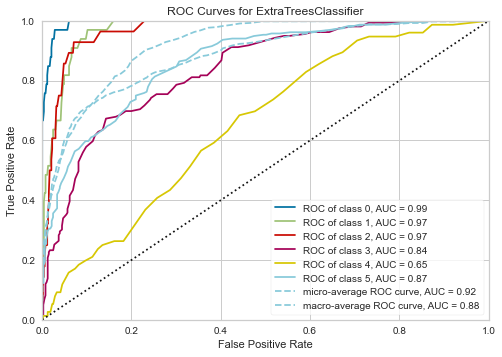

In [34]:
plot_model(et, plot='auc')

> Sensitive 민감도 = TP / TP + FN # 실제 양성 + 맞춘 양성    
Specificity 특이도 = TN / TN + FP # 실제 음성 + 맞춘 음성    
클수록 좋다.     

### ✅Insigt CM 중학교 vs 고등학교 바이너리 분류는 잘하고 있음

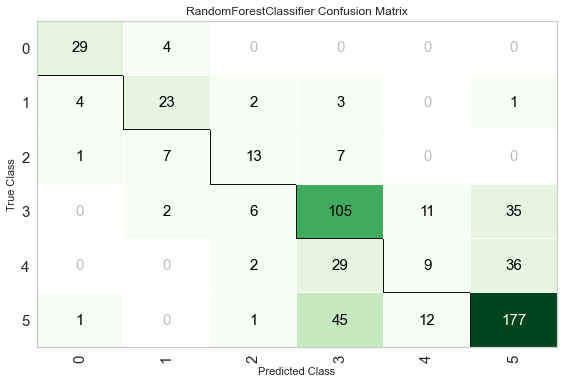

In [35]:
plot_model(rf, plot='confusion_matrix')

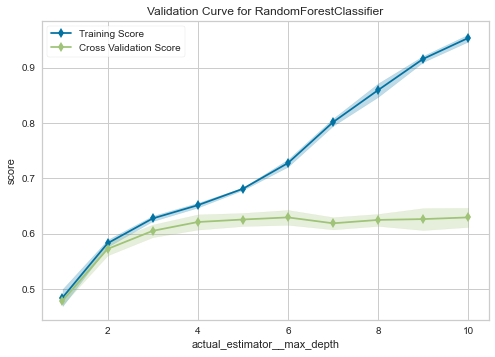

In [36]:
plot_model(rf, plot = 'vc')

> - n_estimators는 클수록 좋습니다.     
>- max_depth는 직접 수를 넣어보며 조절 (과적합 조심)

### ✅ 단어의 길이, 고등학교 1학년 단어, 문장 당 단어 개수, 전치사 개수 중요도가 높다.
> 

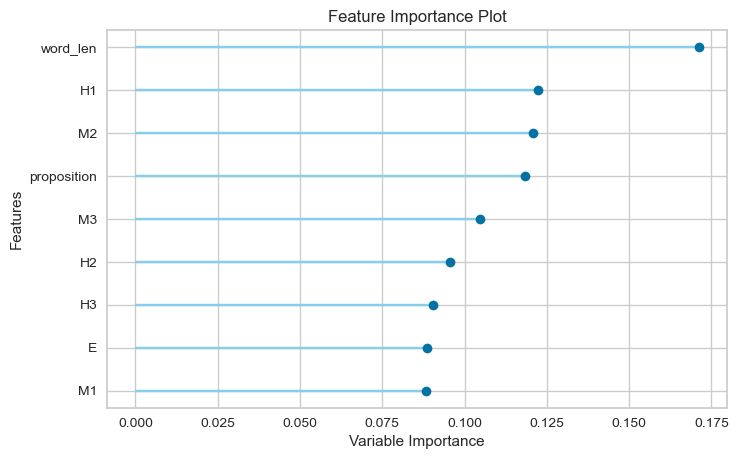

In [64]:
 plot_model(rf, plot = 'feature')

---
## 앙상블 사용
> 단일 모델에 비해 일반화 성능은 아마 더 좋을것이다.

In [38]:
# best5 # ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, LinearDiscriminantAnalysis

### blended models 는 voting + 가중 평균

> `blend_models` = 블랜딩 앙상블    
`predict_model` = 예측값? 의미가 뭐지

`blending` 을 잘활용하기 위해서는 `validation set` 의 `meta-feature` (원래 feature 및 예측값) 을 통해 training 하고   
`test set` 에 대해 성능을 최종 평가


In [39]:
# 블렌딩 앙상블
# blended = blend_models(estimator_list = best5, fold = 3, optimize = 'logloss') 
# pred_holdout = predict_model(blended)


In [40]:
# 스태킹 앙상블
# stacker = stack_models(estimator_list=best5, fold=3, meta_model=et)
# pred_holdout = predict_model(stacker)

---
### 원하는 모델(좋은 모델)만 가져와서 최적화시키기

In [41]:
custom_model = compare_models(fold = 5, sort = 'logloss', n_select = 6, include=['et','rf'])
# pred_customed_holdout = predict_model(custom_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,TT (Sec)
et,Extra Trees Classifier,0.6155,0.8372,0.5961,0.5669,0.5798,0.4592,0.4673,0.9128,0.0900
rf,Random Forest Classifier,0.6307,0.8309,0.6146,0.5919,0.5987,0.4811,0.4888,0.9252,0.0960


In [42]:
blended_custom = blend_models(estimator_list = custom_model, fold = 5, optimize = 'logloss')
pred_holdout_custom = predict_model(blended_custom)
# estimator_list = model list

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.6553,0.8384,0.6417,0.6089,0.6196,0.5155,0.5240,0.9093
1,0.5970,0.8401,0.5392,0.5396,0.5534,0.4233,0.4346,0.9015
2,0.6084,0.8329,0.6206,0.5472,0.5681,0.4458,0.4556,0.9175
3,0.6464,0.8491,0.6367,0.6143,0.6181,0.5097,0.5154,0.9082
4,0.6122,0.8306,0.6297,0.5721,0.5836,0.4583,0.4646,0.9031
Mean,0.6238,0.8382,0.6136,0.5764,0.5886,0.4705,0.4788,0.9079
SD,0.0228,0.0065,0.0379,0.0307,0.0265,0.0362,0.0348,0.0056


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,Voting Classifier,0.6425,0.8488,0.6001,0.6014,0.6144,0.4878,0.4929,0.9280


In [61]:
# blended_custom # RandomForestClassifier, DecisionTreeClassifier

In [62]:
blended_custom.estimators 

[('et',
  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=6687, verbose=0,
                       warm_start=False)),
 ('rf',
  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                         criterion='gini', max_depth=None, max_features='auto',
                         max_leaf_nodes=None, max_samples=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=100,
 

In [44]:
evaluate_model(blended_custom)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

---
### 자동으로 상위 5개 선택한 모델

In [45]:
# #자동으로 상위 5개 선택한 모델
# final_model = finalize_model(blended)
# final_model_custom = finalize_model(blended_custom)

### 2-9. Predict Proba를 위한 추가 절차

In [46]:
# pred_proba없어서
prep_pipe = get_config("prep_pipe")

In [47]:
# 파이프를 다 가져옴.
prep_pipe

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='level',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strat...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_all', 'passthrough'),
                ('dummy', Dummify(target='level')),
                ('fix_perfect', Remov

In [48]:
prep_pipe.steps.append(['trained_model', final_model_custom])

NameError: name 'final_model_custom' is not defined

In [ ]:
# pred = prep_pipe.predict_proba(test)
# pred